# 🧬 AMES Mutagenicity Prediction

## 📖 Dataset Description
Mutagenicity refers to the ability of a drug to induce genetic alterations. Drugs that damage DNA may lead to cell death or other severe adverse effects.

The **AMES test**, developed by Professor Bruce Ames, is a widely used biological assay to assess mutagenicity. It is a short-term bacterial reverse mutation assay that detects many compounds that can cause genetic damage or frameshift mutations.

The **AMES dataset** used here is aggregated from four scientific studies.

- **Task Type**: Binary classification  
- **Input**: SMILES string of a drug molecule  
- **Output**: `1` (mutagenic) or `0` (not mutagenic)  
- **Size**: 7,255 compounds

## 📚 References
Xu, Congying, et al. “In silico prediction of chemical Ames mutagenicity.” Journal of chemical information and modeling 52.11 (2012): 2840-2847.

**License**: CC BY 4.0

## 📦 Imports

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import pandas as pd
from scripts.tdc_dataset_download import TDCDatasetDownloader
from scripts.eda_utils import DatasetLoader, EDAVisualizer, SMARTSPatternAnalyzer
from scripts.featurise import MolecularFeaturiser
from scripts.model_utils import ModelPreprocessor, ModelTrainer

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


______

## 📥 Download AMES Dataset

In [2]:
######################################## Declare category and dataset ######################################## 

category = 'tox'
dataset = 'AMES'

In [ ]:
######################################## Initiate downloader class to download the dataset ######################################## 

downloader = TDCDatasetDownloader(category, dataset)

________

## 📊 Exploratory Data Analysis

In this section, we analyze the AMES mutagenicity dataset to better understand its structure, balance, and molecular content. Exploratory Data Analysis (EDA) helps us uncover patterns, detect anomalies, and gain insights that will guide our preprocessing and modeling steps.

### 1. Load Datasets ###

In [ ]:
######################################## Initialize the dataset loader ######################################## 
loader = DatasetLoader(dataset_name=dataset)

In [ ]:
######################################## Load datasets ######################################## 
main_df, train_df, valid_df, test_df = loader.load_all()

______

### 2. 📦 Dataset Overview ###

Before diving into the analysis, it’s essential to understand the structure of the datasets we’re working with — including the main dataset and the train/validation/test splits.

The function `EDAVisualizer.show_dataset_info()` provides a concise summary of:
- Shape (rows × columns)
- Column names
- Missing values
- Sample preview (via `.head()`)

You can run this by:
```python
EDAVisualizer.show_dataset_info(loader)

```
Alternatively, for specific splits only e.g for just Train and Test Data:
```python
selected_datasets = ['train','test']
EDAVisualizer.show_dataset_info(loader, dataset_names=selected_datasets)



In [ ]:
######################################## Show Dataset Info  ########################################

EDAVisualizer.show_dataset_info(loader)

-----

### 3. 💎 Unique SMILES Analysis ###

Knowing how many unique compounds exist in each dataset helps:
- Measure diversity
- Avoid duplication bias
- Confirm splits are stratified

Run:
```python
EDAVisualizer.compare_unique_smiles(
    dfs=[train_df, valid_df, test_df],
    df_names=['Train', 'Valid', 'Test'],
    smiles_col='Drug'  
)


In [ ]:
######################################## Check Unique  Drug  Count in each dataset  ########################################
print(f"Number of Unique drug count in {dataset} train data is: =====>> {train_df["Drug"].nunique()}\n")
print(f"Number of Unique drug count in {dataset} validation data is: =====>> {valid_df["Drug"].nunique()}\n")
print(f"Number of Unique drug count in {dataset} test data is: =====>> {test_df["Drug"].nunique()}\n")
print(f"Total number of Unique drug count in {dataset} data is: =====>> {main_df["Drug"].nunique()}\n")

In [ ]:
######################################## Compare Unique  Drug  Count Distribution  ########################################
EDAVisualizer.compare_unique_smiles(
    dfs=[train_df, valid_df, test_df],
    df_names=['Train', 'Valid', 'Test'],
    smiles_col='Drug'  
)

_____

### 4. 🧮  Target Class Distribution in dataset ###

Class imbalance is a common challenge in classification tasks. Plotting the distribution of the target labels helps us understand:
- Whether the dataset is balanced
- The dominant class (if any)
- The need for resampling or weighted loss functions

We use:
```python
EDAVisualizer.plot_label_distribution(df)


In [ ]:
########################################  Plot class distribution on Main Dataset ######################################## 
EDAVisualizer.plot_label_distribution(main_df, target_col='Y', title='Main - Target Mutagenicity Distribution')

In [ ]:
########################################  Plot class distribution Comparison between Split Dataset ######################################## 
EDAVisualizer.compare_label_distributions(
    dfs=[train_df, valid_df, test_df], 
    df_names=['Train', 'Valid', 'Test'], 
    target_col='Y'
)

______

### 5. 📏 SMILES Length Analysis ###

SMILES strings vary in length depending on the molecular complexity. Analyzing their length:
- Highlights outliers or unusually long/short molecules
- Informs sequence-based model designs (like RNNs, Transformers)

To analyze the distribution:
```python
EDAVisualizer.check_smiles_length(loader=loader)


In [ ]:
########################################  Check the SMILES Length Distribution of the Full Dataset ######################################## 
EDAVisualizer.check_smiles_length(loader=loader)

In [ ]:
########################################  Alternatively, Check the SMILES Length Distribution of the Selected/Multiple Dataset Splits ######################################## 
EDAVisualizer.check_smiles_length(dfs=[test_df], names=["Test"])


In [ ]:
########################################  Compare the SMILES Length Distribution between Split Dataset ######################################## 

EDAVisualizer.compare_smiles_length(loader=loader)

In [ ]:
######################################## Alternatively, we can compare selected splits dataset by executing below ######################################## 

selected_dfs = [train_df, valid_df]
dataset_names=['Train', 'Validation']


EDAVisualizer.compare_smiles_length(selected_dfs, dataset_names)

_____________

### 5. ✔️ RDKit Molecular Validity Check ###

Not all SMILES strings are guaranteed to represent valid molecules. Some may contain syntax errors or rare patterns RDKit cannot parse.

This function evaluates validity by attempting to convert each SMILES to an RDKit Mol object:
```python
EDAVisualizer.check_molecular_validity(loader=loader)


You can also pass a different column name if your SMILES column isn’t named Drug e.g:

EDAVisualizer.check_molecular_validity(train_df, smiles_col='SMILES')

In [ ]:
######################################## Check Drug Molecular Validity ######################################## 

EDAVisualizer.check_molecular_validity(loader=loader)

____________

### 6. 🧬 Molecular Descriptor Engineering ###
Use RDKit to calculate standard drug-likeness properties for molecules — a key step in both Exploratory Data Analysis (EDA) and featurization.

This function computes key cheminformatics descriptors from SMILES using RDKit:
- Molecular weight (MW)
- LogP (lipophilicity)
- Topological Polar Surface Area (TPSA)
- Hydrogen Bond Donors/Acceptors (HBD/HBA)
- Rotatable bonds
- Ring counts (total and aromatic)

These descriptors provide chemical insights into your dataset during EDA (e.g., distribution of molecular weights) and also serve as informative features for downstream machine learning models.

You can add descriptors to a dataset via:
```python
EDAVisualizer.add_molecular_descriptors(loader=loader)

```
You can also:

🔹 Apply to Specific DataFrames:

```python
EDAVisualizer.add_molecular_descriptors(dfs=[train_df, test_df], names=["Train", "Test"])
```

🔹 Apply to a single DataFrame:

```python
EDAVisualizer.add_molecular_descriptors(dfs=valid_df, names=["Validation"])
```

🔹 Return new DataFrames:

```python
updated = EDAVisualizer.add_molecular_descriptors(dfs=[train_df], inplace=False)

In [ ]:
######################################## Add Molecular Descriptors ######################################## 
EDAVisualizer.add_molecular_descriptors(loader=loader)


_____

### 7. ✨ SMARTS Pattern Matching ###

SMARTS patterns represent functional groups (e.g., nitro groups, amines, halogens). This module detects presence of such substructures and summarizes their occurrence by class.

**Steps**:
1. Use `SMARTSPatternAnalyzer().analyze(df)` to add SMARTS flags.
2. Use `.summarize_patterns(df)` to compare frequency by label.

Example:
```python
smarts_analyzer = SMARTSPatternAnalyzer()
train_df = smarts_analyzer.analyze(train_df)
smarts_analyzer.summarize_patterns(train_df)


In [ ]:
######################################## Initialize SMARTS Pattern Analyzer ######################################## 
analyzer = SMARTSPatternAnalyzer()

In [ ]:
######################################## Detect SMARTS Substructures in Main Dataset ######################################## 

data_with_flags = analyzer.analyze(main_df)

In [ ]:
########################################  Analyze SMARTS Substructures ######################################## 

analyzer.summarize_patterns(data_with_flags)

__________

### 8. 📈 Visualize correlation between features  ###

### Feature Correlation Heatmaps

Correlation matrices help identify:
- Redundant features
- Feature interactions
- Potential for multicollinearity

We visualize correlations for numeric descriptors:
```python
EDAVisualizer.compare_correlation_heatmaps(
    [main_df],
    ["Data"],
    cols=['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds', 'RingCount', 'AromaticRings', 'Y']
)
```

You can also visualize for multiple dataset by:
```python
EDAVisualizer.compare_correlation_heatmaps(
    dfs=[train_df, valid_df, test_df],
    df_names=["Train", "Validation", "Test"],
    cols=['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds', 'RingCount', 'AromaticRings']
)


In [ ]:
######################################## Show Correlation Heatmaps for Molecular Descriptors ######################################## 

EDAVisualizer.compare_correlation_heatmaps(
    [main_df],
    ["Data"],
    cols=['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds', 'RingCount', 'AromaticRings', 'Y']
)


In [ ]:
######################################## Check Correlation Heatmaps across Splits ######################################## 

EDAVisualizer.compare_correlation_heatmaps(
    [main_df, valid_df, test_df],
    ["Train", "Validation", "Test"],
    cols=['MW', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotBonds', 'RingCount', 'AromaticRings', 'Y']
)

### Boxplot of Numeric Features Across Splits

Boxplots give another visual cue on median, spread, and outliers per descriptor.

Use:
```python
EDAVisualizer.compare_boxplots(
    dfs=[train_df, valid_df, test_df],
    df_names=['Train', 'Validation', 'Test'],
    col='MW'
)


In [ ]:
######################################## Compare MW Boxplots ######################################## 

EDAVisualizer.compare_boxplots(
    [main_df],
    ["AMES Data"],
    col='MW'
)

In [ ]:
######################################## Compare MW Boxplots ######################################## 

EDAVisualizer.compare_boxplots(
    [train_df, valid_df, test_df],
    ["Train", "Validation", "Test"],
    col='MW'
)

### Compare Feature Distributions (Histogram)

Distribution shifts between train/test datasets can impact model generalization. Here, we compare numeric descriptor histograms.

Example:
```python
EDAVisualizer.compare_numeric_distribution(
    dfs=[train_df, test_df],
    df_names=['Train', 'Test'],
    col='MW'  # or LogP, TPSA, etc.
)


In [ ]:
######################################## xxxxx ######################################## 

EDAVisualizer.compare_numeric_distribution(
    [train_df, valid_df, test_df],
    ["Train", "Validation", "Test"],
    col='LogP'
)

_____________

### 9. 🔍 Visual Inspection of Molecules ###

Before building models, it’s helpful to get a “chemical feel” for the data by visualizing molecules per class.

This function:
- Randomly samples `n` molecules per class
- Converts them to RDKit molecules
- Displays them with grid labels

Usage:
```python
EDAVisualizer.draw_samples_by_class(main_df, n=4)



In [ ]:
######################################## Visualize "n" samples of molecules per class ########################################
EDAVisualizer.draw_samples_by_class(main_df, n=5)

In [ ]:
######################################## Draw Sample DRUG SMILE ########################################

EDAVisualizer.draw_molecules([
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # Aspirin
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"  # Ibuprofen
])

________

## 🧬 Molecular Featurization using Ersilia Representation Model

### **1. Extended Reduced Graph (ErG)** ###

In this phase, each molecule in the AMES dataset is converted into a numerical vector representation using The **ErG 2D Descriptors** representation model  from the **[Ersilia Model Hub](https://www.ersilia.io/model-hub)**.

> The Extended Reduced Graph (ErG) approach encodes pharmacophoric properties of molecules by describing their pharmacophore nodes.  
> This model (`eos5guo`) captures the size, shape, and functional characteristics of molecules, making it particularly effective for identifying pharmacophoric patterns.  
> It was benchmarked against Daylight fingerprints and outperformed them in 10 out of 11 tasks.  
> ErG descriptors are especially useful in **scaffold hopping**, a key strategy in drug discovery.

📦 **Model:** `eos5guo`  
🔗 **Source Code:** [github.com/ersilia-os/eos5guo](https://github.com/ersilia-os/eos5guo)  
📖 **Reference Publication:** [10.1021/ci050457y](https://pubs.acs.org/doi/10.1021/ci050457y)

### How the process works:

- The `MolecularFeaturiser` class checks if the model is installed. If not, it **automatically fetches it** using the Ersilia Python SDK.
- The `MolecularFeaturiser` can also be initiated using CLI by setting `use_python_api=False`
- Additionally, by setting `auto_serve=True`, the class tries serving using Python SDK first; but if it fails, switches to CLI mode and logs both events and confirms when initialization is successful.
- It then applies the model to the `train`, `val`, and `test` splits of the AMES dataset.
- This will featurize the train, validation, and test splits.
- Each SMILES string is transformed into a high-dimensional vector representation.
- The output is stored as new CSV files (e.g., `train_eos5axz_features.csv`) inside `data/AMES/splits/`.
- Then the featurization can be executed and preview the results.


In [5]:
######################################## Initialize featurizer ########################################
featuriser = MolecularFeaturiser(dataset_name=dataset, model_id="eos5guo")

2025-04-03 12:29:20,426 - INFO - [API] Initializing Ersilia model: eos5guo
2025-04-03 12:29:41,922 - INFO - ✅ Model initialized Succesfully


In [ ]:
######################################## Run featurization across all dataset splits ######################################## 

featuriser.featurise_all_splits()

2025-04-03 05:34:46,558 - INFO - [+] Featurizing /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/splits/train.csv -> /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/splits/train_eos5guo_features.csv
2025-04-03 05:34:58,456 - INFO - Deleted temporary file: /var/folders/5g/d1fz9jw119x57smh9smql2m00000gn/T/tmpr9_heruh.csv
2025-04-03 05:34:58,457 - INFO - Deleted temporary file: /var/folders/5g/d1fz9jw119x57smh9smql2m00000gn/T/tmpr9_heruh_output.csv
2025-04-03 05:34:58,470 - INFO - Attempting to merge labels from /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/AMES.csv
2025-04-03 05:34:58,480 - WARNING - Could not merge labels: 'input'
2025-04-03 05:34:58,875 - INFO - Featurization completed in 12.32 seconds for train split.
2025-04-03 05:34:58,876 - INFO - [+] Featurizing /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/splits/valid.csv -> /Users/taiwoadelakin/Documents/D

In [ ]:
######################################## Load and preview featurized dataset among splits ######################################## 

split_paths = {
    split: featuriser.get_featurized_path(split)
    for split in ["train", "valid", "test"]
}


In [ ]:
######################################## Read featurized Split Datasets ######################################## 

df_feat_train = pd.read_csv(split_paths["train"])
df_feat_valid   = pd.read_csv(split_paths["valid"])
df_feat_test  = pd.read_csv(split_paths["test"])

In [ ]:
######################################## Print Shape of Featurized Splits ######################################## 

print("Featurized Train shape:", df_feat_train.shape)
print("Featurized Validation shape:", df_feat_valid.shape)
print("Featurized Test shape:", df_feat_test.shape)


Featurized Train shape: (5094, 318)
Featurized Validation shape: (728, 318)
Featurized Test shape: (1456, 318)


___________

### **2. Morgan Fingerprints (Binary) Representation** ###

In this phase, each molecule in the dataset is transformed into a fixed-length binary vector using the **Morgan Fingerprints in binary form** model from the **[Ersilia Model Hub](https://www.ersilia.io/model-hub)**.

> Morgan fingerprints are among the most widely used molecular representations in cheminformatics.  
> They generate circular fingerprints by examining atom-centered environments up to a certain radius.  
> This model (`eos4wt0`) uses **radius = 3** and produces **2048-dimensional binary vectors**, where each bit indicates the **presence** of a substructure.  
> This binary form is compact and efficient for tasks where presence/absence is more important than frequency.

📦 **Model:** `eos4wt0`  
🔗 **Source Code:** [github.com/ersilia-os/eos4wt0](https://github.com/ersilia-os/eos4wt0)  
🐳 **DockerHub:** [hub.docker.com/r/ersiliaos/eos4wt0](https://hub.docker.com/r/ersiliaos/eos4wt0)  
📖 **Reference Publication:** [PubMed ID 20426451](https://pubmed.ncbi.nlm.nih.gov/20426451/)


### How the process works:

- The `MolecularFeaturiser` class checks if the model is installed. If not, it **automatically fetches it** using the Ersilia Python SDK.
- The `MolecularFeaturiser` can also be initiated using CLI by setting `use_python_api=False`
- Additionally, by setting `auto_serve=True`, the class tries serving using Python SDK first; but if it fails, switches to CLI mode and logs both events and confirms when initialization is successful.
- It then applies the model to the `train`, `val`, and `test` splits of the AMES dataset.
- This will featurize the train, validation, and test splits.
- Each SMILES string is transformed into a high-dimensional vector representation.
- The output is stored as new CSV files (e.g., `train_eos5axz_features.csv`) inside `data/AMES/splits/`.
- Then the featurization can be executed and preview the results.


In [3]:
######################################## Initialize featurizer ########################################
featuriser = MolecularFeaturiser(dataset_name=dataset, model_id="eos4wt0")

2025-04-03 05:46:26,697 - INFO - [API] Initializing Ersilia model: eos4wt0
2025-04-03 05:46:54,444 - INFO - ✅ Model initialized Succesfully


In [4]:
######################################## Run featurization across all dataset splits ######################################## 

featuriser.featurise_all_splits()

2025-04-03 05:47:03,688 - INFO - [+] Featurizing /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/splits/train.csv -> /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/splits/train_eos4wt0_features.csv
2025-04-03 05:47:22,861 - INFO - Deleted temporary file: /var/folders/5g/d1fz9jw119x57smh9smql2m00000gn/T/tmpsw4r2eoj.csv
2025-04-03 05:47:22,864 - INFO - Deleted temporary file: /var/folders/5g/d1fz9jw119x57smh9smql2m00000gn/T/tmpsw4r2eoj_output.csv
2025-04-03 05:47:22,899 - INFO - Attempting to merge labels from /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/AMES.csv
2025-04-03 05:47:22,921 - WARNING - Could not merge labels: 'input'
2025-04-03 05:47:25,863 - INFO - Featurization completed in 22.17 seconds for train split.
2025-04-03 05:47:25,863 - INFO - [+] Featurizing /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/splits/valid.csv -> /Users/taiwoadelakin/Documents/D

In [ ]:
######################################## Load and preview featurized dataset among splits ######################################## 

split_paths = {
    split: featuriser.get_featurized_path(split)
    for split in ["train", "valid", "test"]
}


In [ ]:
######################################## Read featurized Split Datasets ######################################## 

df_feat_train = pd.read_csv(split_paths["train"])
df_feat_valid   = pd.read_csv(split_paths["valid"])
df_feat_test  = pd.read_csv(split_paths["test"])

In [ ]:
######################################## Print Shape of Featurized Splits ######################################## 

print("Featurized Train shape:", df_feat_train.shape)
print("Featurized Validation shape:", df_feat_valid.shape)
print("Featurized Test shape:", df_feat_test.shape)

___

## 🤖 Modelling

### **1. 📂 Data Preprocessing** ###

This section loads the featurized dataset splits (train, validation, and test) using the `ModelPreprocessor` class from `model_utils.py`.  
The preprocessor intelligently detects the correct feature columns based on a prefix pattern (e.g., `Mol_feat_`, `Drug1_feat_`, etc.) and extracts both the features and the target (`Y`) for modeling.

The usage depends on the nature of your dataset:

---

#### A. 🧬💊 For Single Molecule Datasets
Use this if your featurized dataset includes a single input molecule column (e.g., `Drug`, `SMILES`, or `input`), and features are prefixed with `"Mol_feat_"` (default).

1. Set your dataset name and model ID e.g. `category = 'tox'`, `dataset = 'AMES'`, `model_id = 'eos5guo'`

2. Initialize the preprocessor (Mol_feat_ is default, so no need to specify): `preprocessor = ModelPreprocessor(dataset_name=dataset, model_id=model_id)`

3. Load and split the featurized data: `X_train, y_train, X_valid, y_valid, X_test, y_test = preprocessor.preprocess()`

#### B. 🧬💊🧬💊 For Combination Drug Datasets (e.g. Drug1/Drug2)
Use this when the dataset has two drug inputs (e.g., Drug1, Drug2) and each has been featurized separately. This setup expects features prefixed with `"Drug1_feat_"` and `"Drug2_feat_"`.

1. Set your dataset name,  model ID and feature_prefixes e.g. `category = 'tox'`, `dataset = 'AMES'`, `model_id = 'eos5guo'`, `feature_prefixes = ["Drug1_feat_", "Drug2_feat_"]`

2. Initialize the preprocessor: `preprocessor = ModelPreprocessor(dataset_name=dataset, model_id=model_id, feature_prefix=feature_prefixes)`

3. Load and split the featurized data: `X_train, y_train, X_valid, y_valid, X_test, y_test = preprocessor.preprocess()`

____
    

In [3]:
model_id = "eos5guo"

In [4]:
######################################## Initialize the preprocessor ########################################
preprocessor = ModelPreprocessor(dataset_name=dataset, model_id=model_id)

2025-04-04 18:01:22,039 - INFO - 🚦 Auto-featurise mode is ON
2025-04-04 18:01:22,041 - INFO - 📂 Checking for featurized files in: /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/data/AMES/splits
2025-04-04 18:01:22,043 - INFO - ✅ All featurized files found. Skipping featurisation.


In [5]:
######################################## Load and split the featurized data ########################################
X_train, y_train, X_valid, y_valid, X_test, y_test = preprocessor.preprocess()

2025-04-04 18:01:23,090 - INFO - 📄 Loading featurized split: train_eos5guo_features.csv
2025-04-04 18:01:23,183 - INFO - 📄 Loading featurized split: valid_eos5guo_features.csv
2025-04-04 18:01:23,197 - INFO - 📄 Loading featurized split: test_eos5guo_features.csv
2025-04-04 18:01:23,277 - WARNING - 🧹🗑️ Dropping column 'Mol_feat_key' from X_train because: (dtype=object)
2025-04-04 18:01:23,281 - WARNING - 🧹🗑️ Dropping column 'Mol_feat_key' from X_valid because: (dtype=object)
2025-04-04 18:01:23,283 - WARNING - 🧹🗑️ Dropping column 'Mol_feat_key' from X_test because: (dtype=object)
2025-04-04 18:01:23,285 - INFO - ✅ Preprocessing Complete

2025-04-04 18:01:23,285 - INFO - 📊 Dataset Summary:
2025-04-04 18:01:23,286 - INFO -    • X_train: (5094, 315) =====> y_train: (5094,)
2025-04-04 18:01:23,287 - INFO -    • X_valid: (728, 315) =====> y_valid: (728,)
2025-04-04 18:01:23,287 - INFO -    • X_test:  (1456, 315) =====> y_test:  (1456,)

2025-04-04 18:01:23,288 - INFO - 🏷️ Target Distribution

______

### **2. 🧭 Model Exploration with PyCaret** ###

In this section, **PyCaret**, a powerful low-code machine learning library, was used to quickly explore, compare, and evaluate multiple classification models on the featurized dataset.

### ❓ Why PyCaret?

PyCaret helps to:

- Run a **head-to-head comparison** of dozens of classifiers in seconds
- Get performance metrics like Accuracy, AUC, Recall, Precision, and F1
- Select a **baseline model** that performs well before deeper tuning
- Export results and seamlessly switch to custom training

It accelerates the modeling phase while allowing for later refinement or swap models using custom code.


### 💡 How To Use It

There's an encapsulated PyCaret logic inside the custom `ModelTrainer` class in `scripts/model_utils.py`. Here's what happens:

1. **Initialize `ModelTrainer`** with preprocessed train/valid/test sets.
2. **Run `run_pycaret()`** to start the AutoML workflow.
3. **Call `log_results()`** to review the top-performing models.
4. **Optionally use `tune_model_with_pycaret()`** to fine-tune a specific model.
5. Save, evaluate, or continue with the selected model.


In [6]:
######################################## Initialize trainer ########################################
trainer = ModelTrainer(X_train, y_train, X_valid, y_valid, X_test, y_test, experiment_name=dataset)

In [7]:
######################################## Run PyCaret AutoML ########################################
trainer.run_pycaret()

⚙️ Initializing PyCaret...


,Description,Value
0,Session id,42
1,Target,Y
2,Target type,Binary
3,Original data shape,"(5094, 316)"
4,Transformed data shape,"(5094, 316)"
5,Transformed train set shape,"(3565, 316)"
6,Transformed test set shape,"(1529, 316)"
7,Numeric features,315
8,Preprocess,True
9,Imputation type,simple


⚖️ Comparing models...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7621,0.8336,0.7654,0.7900,0.7771,0.5222,0.5231,0.1770
lightgbm,Light Gradient Boosting Machine,0.7621,0.8307,0.7561,0.7956,0.7750,0.5230,0.5243,0.4540
et,Extra Trees Classifier,0.7585,0.8240,0.7514,0.7926,0.7712,0.5158,0.5170,0.1550
xgboost,Extreme Gradient Boosting,0.7560,0.8263,0.7581,0.7845,0.7709,0.5100,0.5106,0.1360
gbc,Gradient Boosting Classifier,0.7346,0.7998,0.7333,0.7674,0.7497,0.4676,0.4685,0.4950
dt,Decision Tree Classifier,0.7276,0.7478,0.7162,0.7661,0.7402,0.4546,0.4559,0.0430
lda,Linear Discriminant Analysis,0.7144,0.7610,0.7266,0.7416,0.7338,0.4259,0.4263,0.0480
ridge,Ridge Classifier,0.7142,0.7631,0.7250,0.7419,0.7332,0.4255,0.4258,0.0270
ada,Ada Boost Classifier,0.7116,0.7615,0.7141,0.7439,0.7284,0.4213,0.4221,0.1330
lr,Logistic Regression,0.7094,0.7666,0.7172,0.7393,0.7277,0.4162,0.4169,0.5820


✅ Best model selected: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [8]:
######################################## View PyCaret Leaderboard ########################################
trainer.log_results()

📋 PyCaret Leaderboard:


,Model,Accuracy,AUC,Recall,F1,Kappa,TT (Sec)
rf,Random Forest Classifier,0.7621,0.8336,0.7654,0.7771,0.5222,0.177
lightgbm,Light Gradient Boosting Machine,0.7621,0.8307,0.7561,0.7750,0.5230,0.454
et,Extra Trees Classifier,0.7585,0.8240,0.7514,0.7712,0.5158,0.155
xgboost,Extreme Gradient Boosting,0.7560,0.8263,0.7581,0.7709,0.5100,0.136
gbc,Gradient Boosting Classifier,0.7346,0.7998,0.7333,0.7497,0.4676,0.495


_____

### **3. 🛠️ Hyperparameter Tuning with PyCaret** ###

After selecting the best baseline model by PyCaret, the `tune_model()` function can be used to suggest optimization for its hyperparameters.

### ❓Why Tune?

- To try and improve performance 
- Explore different parameters like tree depths, number of estimators, splits, etc.
- Let PyCaret automatically test multiple parameter combinations and choose the best.

This uses the `tune_model_with_pycaret()` method from the `ModelTrainer` class in `scripts/model_utils.py`.


##### 1️⃣  Top ranked model selected by PyCaret (Random Forest 🌳)
Random Forest was selected as the best-performing model during the initial PyCaret AutoML comparison. To further enhance its performance, PyCaret’s `tune_model()` utility was applied.

This tuning step performs an optimized search over different hyperparameter combinations (e.g., number of trees, maximum depth, split criteria) and selects the configuration that yields the best performance on cross-validation folds.

The goal here is to explore the upper bound of Random Forest’s potential before making final comparisons or selections.

In [9]:
######################################## Tune the top model selected by PyCaret (Random Forest) ########################################
pyC_tuned_rf = trainer.tune_model_with_pycaret(RandomForestClassifier(), n_iter=150)

🛠️ Tuning RandomForestClassifier...


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:01:56
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7843,0.8361,0.7577,0.8305,0.7925,0.5689,0.5715
1,0.7395,0.7912,0.7617,0.7577,0.7597,0.4753,0.4753
2,0.7787,0.8409,0.7409,0.8314,0.7836,0.5587,0.5626
3,0.7479,0.8218,0.7409,0.7814,0.7606,0.4948,0.4955
4,0.7535,0.8297,0.6995,0.8182,0.7542,0.5100,0.5163
5,0.7528,0.8342,0.7150,0.8070,0.7582,0.5073,0.5111
6,0.7753,0.8265,0.7461,0.8229,0.7826,0.5512,0.5540
7,0.7472,0.8197,0.7098,0.8012,0.7527,0.4961,0.4999
8,0.7753,0.8417,0.7565,0.8156,0.7849,0.5503,0.5521


Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


##### 2️⃣  Second Ranked model selected by PyCaret (Light Gradient Boosting Machine 🌀)

Since LightGBM was the second-best model from PyCaret’s AutoML comparison, it'll now be tuned to see if hyperparameter optimization can improve its performance.

PyCaret’s `tune_model()` function will automatically try multiple configurations (by default, 50) using cross-validation and return the best one.

This step helps to explore the LightGBM model’s potential with smarter settings, and allows to benchmark it more fairly against the best model so far (Random Forest).

In [10]:
######################################## Tune the second model selected by PyCaret (Light GBM) ########################################
pyC_tuned_lgbm = trainer.tune_model_with_pycaret(LGBMClassifier(), n_iter=150)

🛠️ Tuning LGBMClassifier...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7759,0.8536,0.7474,0.8239,0.7838,0.5524,0.5552
1,0.7367,0.8128,0.7876,0.7415,0.7638,0.4670,0.4680
2,0.7787,0.8461,0.7824,0.8032,0.7927,0.5555,0.5557
3,0.7395,0.8123,0.7461,0.7660,0.7559,0.4767,0.4769
4,0.7815,0.8495,0.7720,0.8142,0.7926,0.5621,0.5630
5,0.7865,0.8422,0.7824,0.8162,0.7989,0.5716,0.5722
6,0.7697,0.8475,0.7720,0.7968,0.7842,0.5374,0.5377
7,0.7388,0.8151,0.7202,0.7809,0.7493,0.4775,0.4792
8,0.7500,0.8399,0.7513,0.7796,0.7652,0.4981,0.4985


Fitting 10 folds for each of 150 candidates, totalling 1500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Metric,PyCaret Tuned - Random Forest,PyCaret Tuned - LightGBM
0,Accuracy,0.743132,0.743132
1,F1 Score,0.769420,0.769420
2,Precision,0.791878,0.791878
3,Recall,0.748201,0.748201
4,AUC,0.823224,0.834262
5,Kappa,0.480024,0.480024
6,MCC,0.481009,0.481009


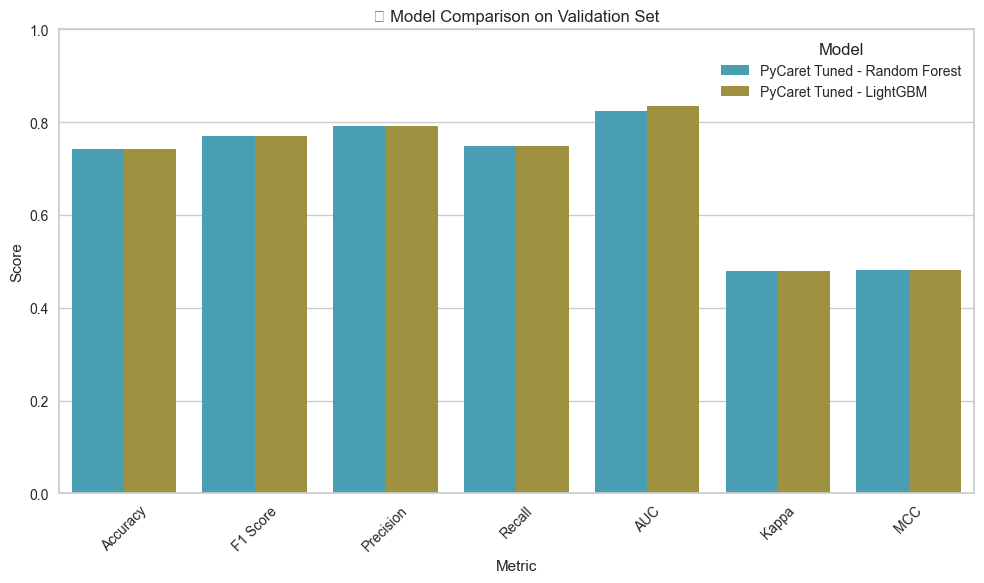

In [11]:
######################################## Compare Pycaret Best Models Evaluation ########################################
trainer.compare_models_on_metrics(models=[pyC_tuned_rf, pyC_tuned_lgbm], model_names=["PyCaret Tuned - Random Forest", "PyCaret Tuned - LightGBM"])

______

### **4. 🔧 Hyperparameter Tuning with GridSearchCV** ###

In this section, the hyperparameters of the top-performing models from PyCaret are manually tuned using `GridSearchCV`. The goal is to fine-tune the model performance beyond the AutoML tuning provided by PyCaret.


#### ❓ Why use GridSearchCV?
While PyCaret has already given a solid baseline and performed automatic tuning, `GridSearchCV` provides:

- 🕹️ **Full control** over the hyperparameter space  
- 🔁 **Cross-validation** to ensure generalization of the model  
- 🪞 **Transparency**: We explicitly define and test parameter combinations  
- 🦾 **Flexibility**: Easy to apply across different models and use cases


This process will be applied to both:
1. **Random Forest** – the best performer from PyCaret AutoML
2. **LightGBM** – the second-best with very close metrics

Once each model is tuned:
- It’ll be trained using the best parameters from GridSearch
- Then compare their **final evaluation metrics side-by-side**

> This will help choose the most reliable model.

##### 1️⃣ GridSearchCV: Random Forest 🌳

In [12]:
######################################## Define parameter grid for Random Forest tuning ########################################

rf_param_grid = {
    "n_estimators": list(range(50, 201, 50)),
    "max_depth": [None] + list(range(5, 31, 5)),
    "min_samples_split": list(range(2, 5)),
    "min_samples_leaf": list(range(1, 4)),
    "max_features": ["sqrt", "log2"]
}

In [13]:
######################################## Initialize the model ########################################
rf_base = RandomForestClassifier(random_state=42)

In [14]:
# Setup GridSearchCV
rf_grid = GridSearchCV(
    estimator=rf_base,
    param_grid=rf_param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

In [15]:
# Fit GridSearchCV on training data
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='sqrt',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              monotonic_cst=None,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 15, 20, 25, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [50, 100, 150, 200]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [16]:
######################################## Best GridCV Parameters for RF ########################################
print(f"🔍 Best GridCV Parameters (Random Forest):\n {rf_grid.best_params_}")

🔍 Best GridCV Parameters (Random Forest):
 {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200}


In [17]:
########################################  Retrieve best params and reinstantiate clean model ########################################
bestGrid_rf = RandomForestClassifier(**rf_grid.best_params_, random_state=42)

In [18]:
######################################## Train model with best GridSearchCV params ########################################
trained_rf = trainer.train_selected_model(bestGrid_rf)

🔧 Training selected model: RandomForestClassifier


In [19]:
######################################## Evaluate model on validation set ########################################
trainer.evaluate_model(trained_rf)

📊 Evaluation Metrics:
Accuracy: 0.7445
AUC: 0.8398
Recall: 0.7554
Precision: 0.7895
F1 Score: 0.7721
Kappa: 0.4818
MCC: 0.4824
Time taken (seconds): 0.05


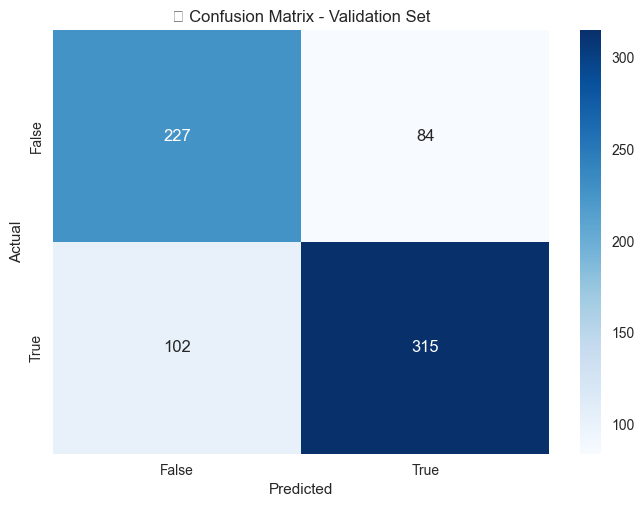

In [20]:
######################################## Plot confusion matrix ########################################
trainer.plot_confusion_matrix(trained_rf)

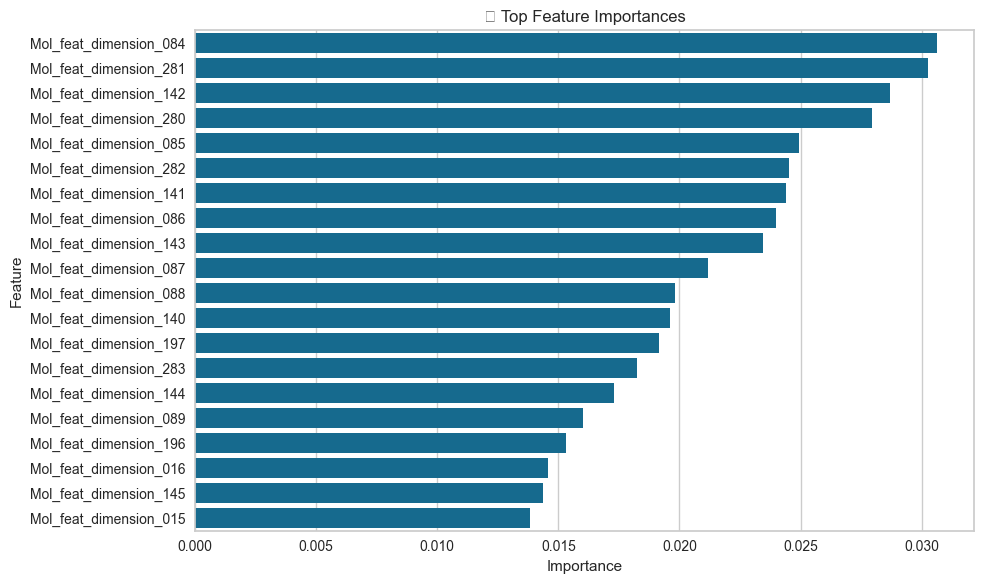

In [21]:
######################################## Plot feature importances (for tree-based models) ########################################
trainer.plot_feature_importance()

,Metric,PyCaret - Random Forest,GridCV - Random Forest
0,Accuracy,0.743132,0.744505
1,F1 Score,0.769420,0.772059
2,Precision,0.791878,0.789474
3,Recall,0.748201,0.755396
4,AUC,0.823224,0.839764
5,Kappa,0.480024,0.481755
6,MCC,0.481009,0.482362


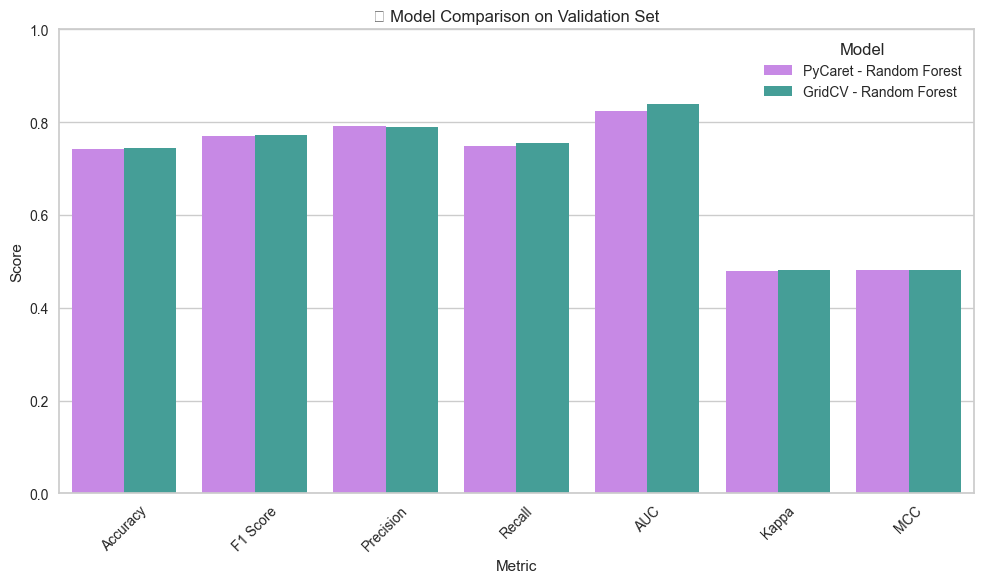

In [22]:
######################################## Compare Pycaret RF Models  vs GridCV RF Model on Validation Set ########################################

trainer.compare_models_on_metrics(models=[pyC_tuned_rf, bestGrid_rf], model_names=["PyCaret - Random Forest", "GridCV - Random Forest"])

,Metric,PyCaret - Random Forest,GridCV - Random Forest
0,Accuracy,0.768544,0.788462
1,F1 Score,0.784113,0.802817
2,Precision,0.802097,0.820681
3,Recall,0.766917,0.785714
4,AUC,0.841617,0.861360
5,Kappa,0.534938,0.574902
6,MCC,0.535563,0.575536


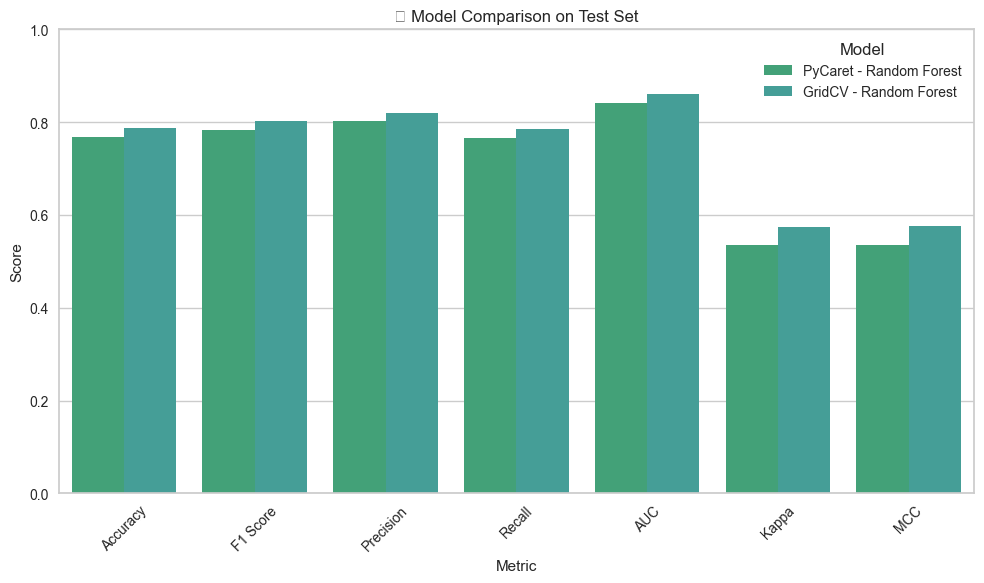

In [23]:
######################################## Compare Pycaret RF Models  vs GridCV RF Model on Test Set ########################################

trainer.compare_models_on_metrics(models=[pyC_tuned_rf, bestGrid_rf], model_names=["PyCaret - Random Forest", "GridCV - Random Forest"], dataset="test")

______

##### 2️⃣ GridSearchCV: Light Gradient Boosting Machine 🌀

In [24]:
######################################## Define LightGBM Param Grid ########################################
# lgbm_param_grid = {
#     "n_estimators": list(range(50, 201, 50)),
#     "max_depth": [None] + list(range(5, 31, 5)),
#     "learning_rate": [0.01, 0.05, 0.1],
#     "num_leaves": [15, 31, 63],
#     "min_child_samples": [10, 20, 30],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
# }

lgbm_param_grid = {
    "n_estimators": [100, 150],
    "max_depth": [None, 10, 20],
    "learning_rate": [0.05, 0.1],
    "min_child_samples": [10],              
    "subsample": [0.8, 1.0],                      
    "colsample_bytree": [0.8, 1.0],               
}

In [25]:
######################################## Setup GridSearchCV for LightGBM ########################################
lgbm_base = LGBMClassifier(random_state=42)

In [26]:
######################################## Setup GridSearchCV ########################################
lgbm_grid = GridSearchCV(
    estimator=lgbm_base,
    param_grid=lgbm_param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

In [27]:
######################################## Run GridSearch for LightGBM ########################################
lgbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Number of positive: 2759, number of negative: 2335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5823
[LightGBM] [Info] Number of data points in the train set: 5094, number of used features: 286
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541618 -> initscore=0.166856
[LightGBM] [Info] Start training from score 0.166856


GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=None, num_leaves=31,
                                      objective=None, random_state=42,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.05, 0.1],
                         'max_depth': [None, 10, 20], 'min_child_samples': [10],
                         'n_estimators': [100, 150], 'subsample': [0.8, 1.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [28]:
######################################## Get Best LightGBM Params ########################################
print("📌 Best Parameters:", lgbm_grid.best_params_)

📌 Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': None, 'min_child_samples': 10, 'n_estimators': 150, 'subsample': 0.8}


In [29]:
######################################## Extract the best LightGBM model found during GridSearchCV ########################################
bestGrid_lgbm = lgbm_grid.best_estimator_

In [30]:
######################################## Train Tuned LightGBM ########################################
trained_lgbm = trainer.train_selected_model(bestGrid_lgbm)

🔧 Training selected model: LGBMClassifier
[LightGBM] [Info] Number of positive: 2759, number of negative: 2335
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5823
[LightGBM] [Info] Number of data points in the train set: 5094, number of used features: 286
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541618 -> initscore=0.166856
[LightGBM] [Info] Start training from score 0.166856


In [31]:
######################################## Evaluate Tuned LightGBM ########################################
trainer.evaluate_model(trained_lgbm)

📊 Evaluation Metrics:
Accuracy: 0.7637
AUC: 0.8521
Recall: 0.7650
Precision: 0.8117
F1 Score: 0.7877
Kappa: 0.5219
MCC: 0.5231
Time taken (seconds): 0.07


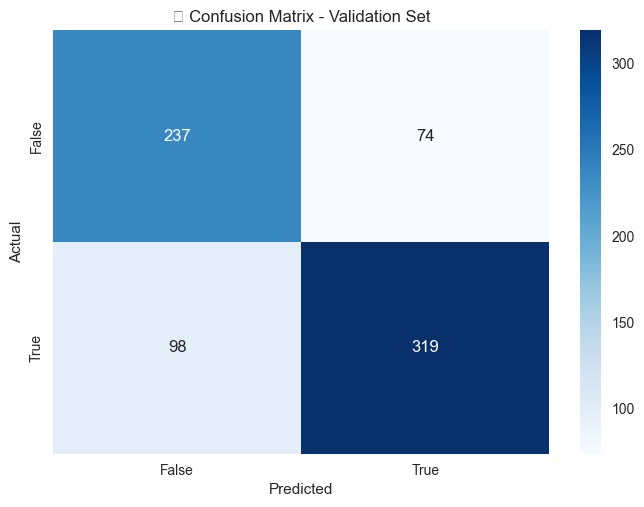

In [32]:
######################################## LightGBM Confusion Matrix ########################################
trainer.plot_confusion_matrix(trained_lgbm)

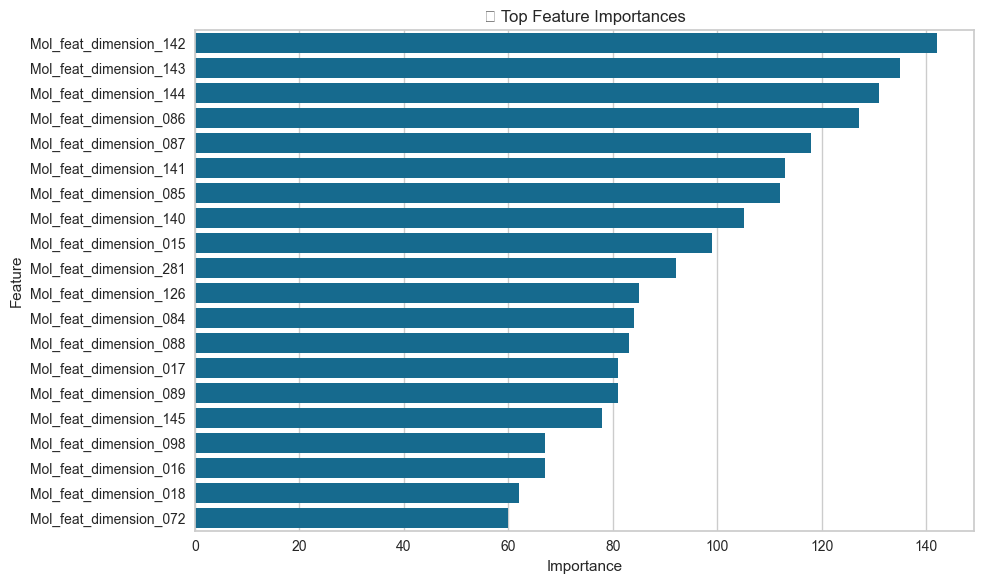

In [33]:
######################################## Feature Importance Plot for LightGBM ########################################
trainer.plot_feature_importance()

,Metric,PyCaret - LightGBM,GridCV - LightGBM
0,Accuracy,0.743132,0.763736
1,F1 Score,0.769420,0.787654
2,Precision,0.791878,0.811705
3,Recall,0.748201,0.764988
4,AUC,0.834262,0.852117
5,Kappa,0.480024,0.521927
6,MCC,0.481009,0.523092


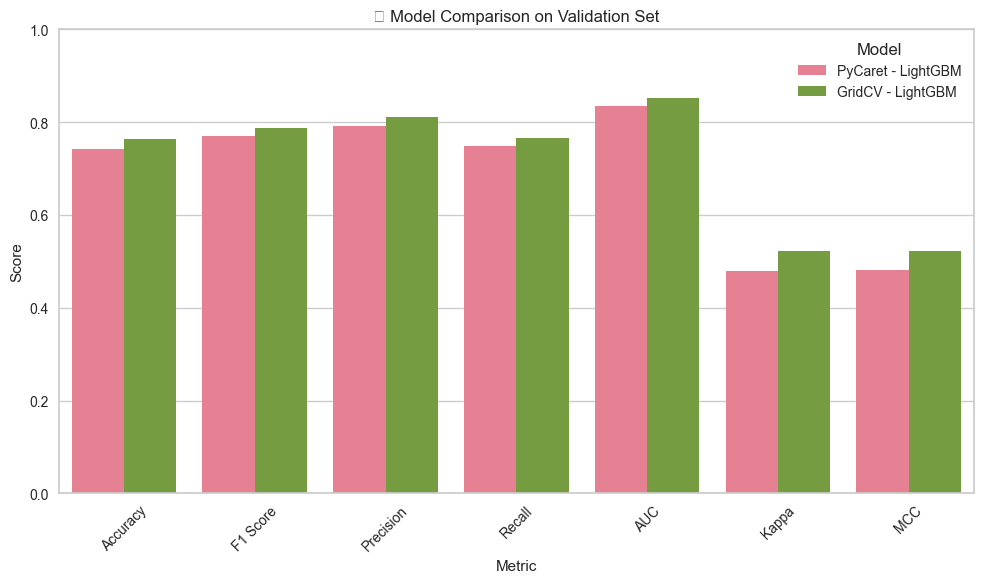

In [34]:
######################################## Compare Pycaret LightGBM Models  vs GridCV LightGBM Model on Validation Set ########################################

trainer.compare_models_on_metrics(models=[pyC_tuned_lgbm, bestGrid_lgbm], model_names=["PyCaret - LightGBM", "GridCV - LightGBM"])

,Metric,PyCaret - LightGBM,GridCV - LightGBM
0,Accuracy,0.775412,0.787088
1,F1 Score,0.789711,0.802043
2,Precision,0.811096,0.817708
3,Recall,0.769424,0.786967
4,AUC,0.845398,0.864530
5,Kappa,0.549097,0.571914
6,MCC,0.549977,0.572406


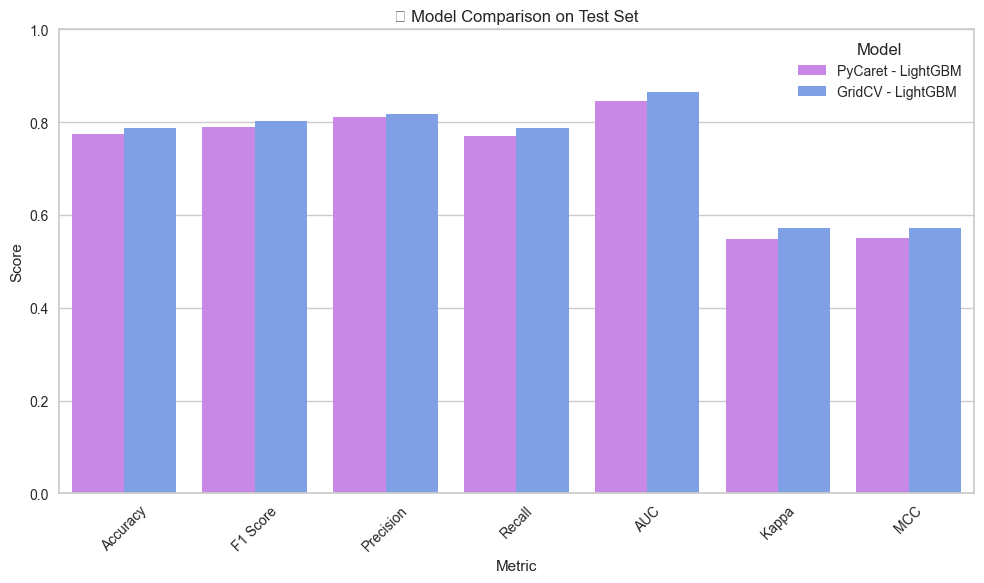

In [35]:
######################################## Compare Pycaret LightGBM Models  vs GridCV LightGBM Model on Test Set ########################################

trainer.compare_models_on_metrics(models=[pyC_tuned_lgbm, bestGrid_lgbm], model_names=["PyCaret - LightGBM", "GridCV - LightGBM"], dataset="test")

_______

### **5. ☑️ Select Model and Save** ###

After benchmarking multiple models—through both **automated tuning using PyCaret** and **manual tuning with GridSearchCV**, the **best-performing model** will be selected based on key evaluation metrics like **F1-score**, **AUC**, and overall robustness.

This step finalizes the modeling pipeline by preserving the most optimized model for future use.

#### What to do:

☑️ **Select** the model that consistently performs best or very well 
💾 **Save** the model using `joblib` for reuse in inference, deployment, or testing  
♻️ **Ensure reproducibility** without needing to retrain


,Metric,Random Forest,Light GBM
0,Accuracy,0.744505,0.763736
1,F1 Score,0.772059,0.787654
2,Precision,0.789474,0.811705
3,Recall,0.755396,0.764988
4,AUC,0.839764,0.852117
5,Kappa,0.481755,0.521927
6,MCC,0.482362,0.523092


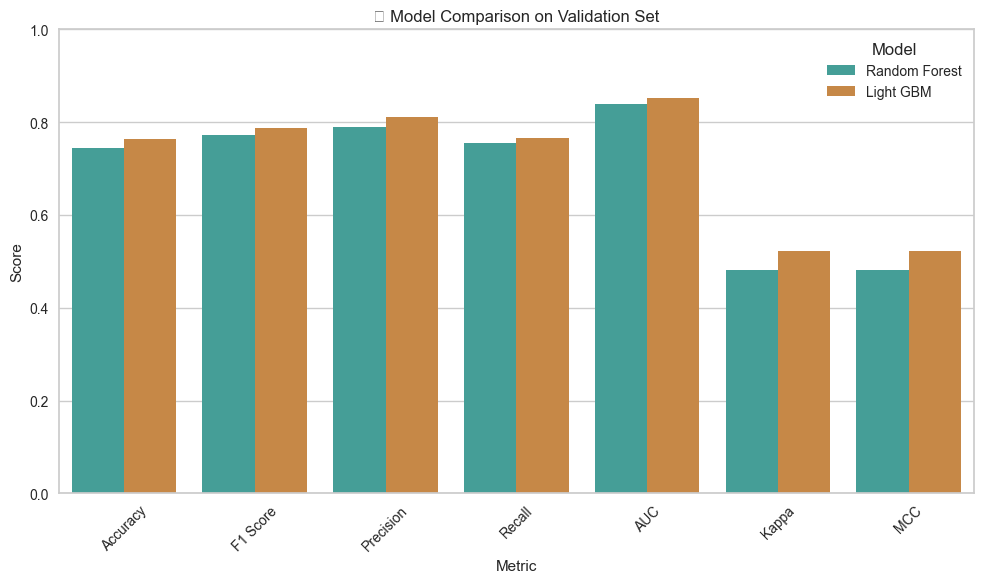

In [36]:
######################################## Compare Random Forest Model  vs LightGBM Model on Validation Set ########################################

trainer.compare_models_on_metrics(models=[bestGrid_rf, bestGrid_lgbm], model_names=["Random Forest", "Light GBM"])

,Metric,Random Forest,Light GBM
0,Accuracy,0.788462,0.787088
1,F1 Score,0.802817,0.802043
2,Precision,0.820681,0.817708
3,Recall,0.785714,0.786967
4,AUC,0.861360,0.864530
5,Kappa,0.574902,0.571914
6,MCC,0.575536,0.572406


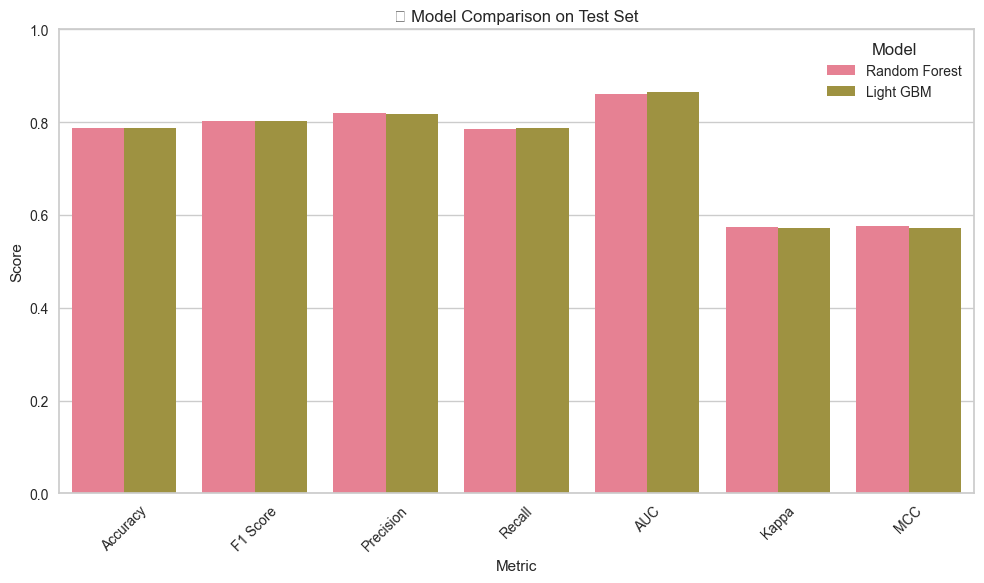

In [37]:
######################################## Compare Random Forest Model  vs LightGBM Model on Test Set ########################################

trainer.compare_models_on_metrics(models=[bestGrid_rf, bestGrid_lgbm], model_names=["Random Forest", "Light GBM"], dataset="test")

In [ ]:
######################################## Save Model  ########################################
trainer.save_model(model = bestGrid_lgbm, dataset_name=dataset, featurizer_id=model_id)
trainer.save_model(model= bestGrid_rf, dataset_name=dataset, featurizer_id=model_id)

💾 Model saved to: /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/models/ames/ames_eos5guo_lgbmclassifier.pkl
💾 Model saved to: /Users/taiwoadelakin/Documents/Doc/Projects/outreachy-contributions/models/ames/ames_eos5guo_randomforestclassifier.pkl


______